In [6]:
import yaml
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load YAML data
def load_yaml_articles(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        articles = yaml.safe_load(file)
    return articles


articles = load_yaml_articles('../articles.yaml')

In [11]:
from urllib.parse import urlparse
import re

def extract_topics_from_url(url, skip_last_n=2):
    path = urlparse(url).path
    parts = [part for part in path.strip("/").split("/") if part]

    if len(parts) > skip_last_n:
        topics = parts[:-skip_last_n]
    else:
        topics = []

    # Replace hyphens with spaces, remove numbers if needed, clean up
    topics = [re.sub(r'[-_]+', ' ', topic) for topic in topics]

    return topics


In [12]:
# Assuming articles are loaded like this:
# articles = load_yaml_articles('articles.yaml')

for article in articles:
    article['url_topics'] = extract_topics_from_url(article['url'])

# Verify:
print(articles[0]['url_topics'])

['svet', 'preberite tudi']


In [13]:
num = 2
print(articles[num].get('topics'))
print(articles[num].get('url'))

slovenija
https://www.rtvslo.si/slovenija/preberite-tudi/v-veljavi-podrazitve-napotitev-delavcev/693324


In [14]:
# Extract representative texts from articles
def get_article_text(article):
    text_parts = [
        article.get('title', ''),
        article.get('lead', ''),
        ' '.join(article.get('paragraphs', [])),
    ]
    return ' '.join(text_parts)
    
# Prepare data
texts = [get_article_text(article) for article in tqdm(articles, desc="Processing articles")]


Processing articles: 100%|██████████| 29493/29493 [00:00<00:00, 255154.78it/s]


In [9]:
# ----------- SBERT Embeddings ----------- #
#print("Generating SBERT embeddings...")
#sbert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
#sbert_embeddings = sbert_model.encode(texts, batch_size=64, show_progress_bar=True)

#np.save('sbert_embeddings.npy', sbert_embeddings)

In [ ]:
sbert_embeddings = np.load('sbert_embeddings.npy') 

In [ ]:
# # ----------- UMAP Reduction ----------- #
# print("Reducing dimensionality with UMAP...")
umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)

# print("UMAP on TF-IDF embeddings...")
# tfidf_umap = umap_reducer.fit_transform(tfidf_embeddings)

# print("UMAP on SBERT embeddings...")
sbert_umap = umap_reducer.fit_transform(sbert_embeddings)

# np.save('sbert_umap.npy', sbert_umap)
# np.save('tfidf_umap.npy', tfidf_umap)


In [ ]:
#sbert_umap = np.load('sbert_umap.npy')

t-SNE tends to form tight, visually appealing clusters. It emphasizes local neighborhood relationships strongly. While visually clearer, it can over-emphasize local neighborhoods, potentially fragmenting larger semantic clusters into artificially small subgroups.
UMAP achieves a balance between local and global structure, providing a slightly more faithful semantic representation at the expense of somewhat less visually dramatic cluster separation compared to t-SNE. UMAP embeddings typically preserve semantic continuity and relationships between clusters better than t-SNE.

Fitting PCA...


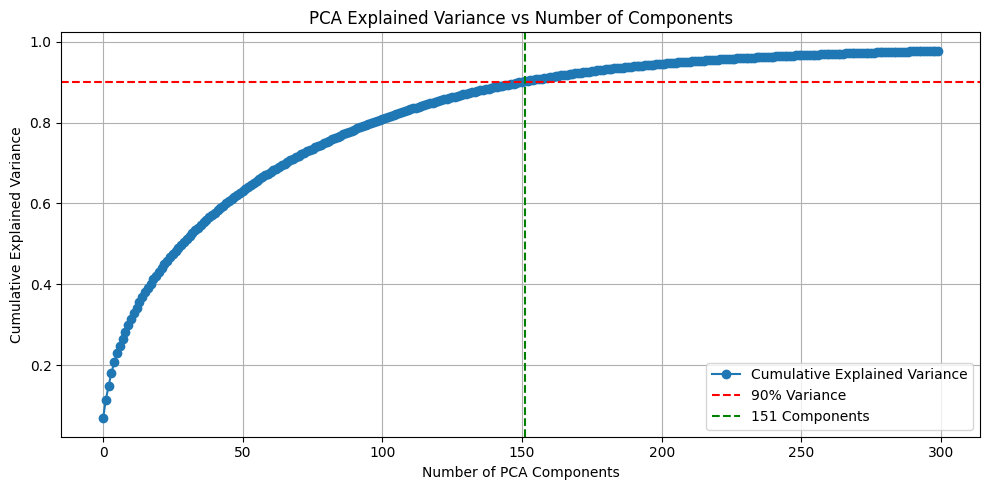

✅ 151 components retain 90% of the variance.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_variance(embeddings, variance_threshold=0.90):
    print("Fitting PCA...")
    pca = PCA(n_components=min(300, embeddings.shape[1]))  # limit to 300 or max dims
    pca.fit(embeddings)

    # Cumulative sum of explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find how many components are needed to reach the threshold
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{int(variance_threshold * 100)}% Variance')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance vs Number of Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"✅ {num_components} components retain {variance_threshold*100:.0f}% of the variance.")
    return num_components

n_components_needed = plot_pca_variance(sbert_embeddings, variance_threshold=0.90)

In [ ]:
from sklearn.decomposition import PCA

# Reduce SBERT embeddings to ~50D before HDBSCAN
#pca = PCA(n_components=150, random_state=42)
#sbert_reduced = pca.fit_transform(sbert_embeddings)



In [17]:
from sklearn.preprocessing import normalize

#umap_50d = UMAP(n_components=50, metric='cosine').fit_transform(sbert_embeddings)
umap_25d = UMAP(n_components=25, metric='cosine').fit_transform(sbert_embeddings)
#normalized_embeddings = normalize(umap_50d, norm='l2')  # unit vectors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
#sloberta_embeddings = np.load("sloberta_embeddings.npy")
#sloberta_umap_25d = UMAP(n_components=25, metric='cosine').fit_transform(sloberta_embeddings)

In [ ]:
#umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
#sloberta_umap = umap_reducer.fit_transform(sloberta_embeddings)

|^| not good: PCA = linear dimensionality reduction
It keeps axes that preserve the largest variance.
But semantic similarity ≠ variance.
In text embeddings (especially SBERT), semantic structure may exist in nonlinear manifolds.
Result:
PCA might preserve noise or background features (e.g. writing style, length).
It may flatten meaningful nonlinear relationships.

In [223]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def fix_cluster_noise_with_knn(embeddings, cluster_labels, n_neighbors=5):
    """
    Reassigns HDBSCAN noise points (-1 labels) using KNN fallback.
    
    Args:
        embeddings (np.ndarray): 2D or reduced embeddings (e.g., UMAP).
        cluster_labels (np.ndarray): Cluster labels from HDBSCAN or approximate_predict().
        n_neighbors (int): Number of neighbors for KNN.

    Returns:
        np.ndarray: Final labels with no -1s (all points assigned).
    """
    cluster_labels = np.array(cluster_labels)
    noise_mask = cluster_labels == -1

    if not np.any(noise_mask):
        print("✅ No noise points to reassign. Returning original labels.")
        return cluster_labels

    print(f"🔄 Reassigning {np.sum(noise_mask)} noise points using KNN...")

    # Prepare training data (only confidently labeled points)
    X_train = embeddings[~noise_mask]
    y_train = cluster_labels[~noise_mask]

    # Train KNN and predict noise points
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    reassigned = knn.predict(embeddings[noise_mask])

    # Merge reassigned labels back into full label array
    final_labels = cluster_labels.copy()
    final_labels[noise_mask] = reassigned

    print("✅ All points now have a cluster assignment.")
    return final_labels


good clustering config:
25 clusters:
clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=100, metric='euclidean', prediction_data=True, cluster_selection_method='leaf')

clusterer_sbert.fit(umap_25d)
sbert_clusters_sparse, strengths = approximate_predict(clusterer_sbert, umap_25d)
sbert_clusters = fix_cluster_noise_with_knn(umap_25d, sbert_clusters_sparse)


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score


def cluster_with_kmeans(embeddings, n_clusters=20, random_state=42):
    """
    Clusters the given embeddings using KMeans.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features)
        n_clusters (int): Number of clusters to create
        random_state (int): For reproducibility

    Returns:
        clusters (np.ndarray): Cluster labels for each item
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Example usage
#sbert_clusters = cluster_with_kmeans(umap_25d, n_clusters=15)

# ----------- Clustering with HDBSCAN ----------- #
print("Clustering with HDBSCAN...")
# clusterer_tfidf = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
# tfidf_clusters = clusterer_tfidf.fit_predict(tfidf_embeddings)

# Cluster with precomputed cosine distances
# TODO: min cluster size
#clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=150, metric='euclidean', prediction_data=True, cluster_selection_method='leaf')
# TODO: for report
#sbert_clusters = clusterer_sbert.fit_predict(sbert_umap)
#sbert_clusters = clusterer_sbert.fit_predict(umap_25d)
from hdbscan import approximate_predict

# Use HDBSCAN’s built-in prediction (only if `prediction_data=True`)
clusterer_sbert.fit(umap_25d)
sbert_clusters_sparse, strengths = approximate_predict(clusterer_sbert, umap_25d)
sbert_clusters = fix_cluster_noise_with_knn(umap_25d, sbert_clusters_sparse)

topic_strings = [
    "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]
le = LabelEncoder()
topic_labels = le.fit_transform(topic_strings)

# Evaluate clustering
def draw_graph():
    ari_score = []
    nmi_score = []
    silhouette = []
    chz = []

    for n in range(2, 30):
        sbert_clusters = cluster_with_kmeans(umap_25d, n_clusters=n)

        ari_score.append(adjusted_rand_score(topic_labels, sbert_clusters))
        nmi_score.append(normalized_mutual_info_score(topic_labels, sbert_clusters))
        silhouette.append(silhouette_score(umap_25d, sbert_clusters))
        #chz.append(calinski_harabasz_score(umap_25d, sbert_clusters))
        print(n)
    
    plt.figure(figsize=(10, 6))

    x = list(range(2, 30))
    plt.plot(x, silhouette, label='Silhouette Score', marker='o')
    #plt.plot(x, chz, label='Calinski-Harabasz', marker='s')
    plt.plot(x, nmi_score, label='NMI', marker='^')
    plt.plot(x, ari_score, label='ARI', marker='x')

    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.title("Clustering Evaluation Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#draw_graph()

Silhouette doesnt capture everything, since high dimensional embedding. The number of groups wanted is around 15-25 based on dbscan, but would like closer to 15-20 because they become hard to understand and describe with keywords, especially sports. I balanced three scores, where ari and nmi represented clustering also with regard to how true labels clustered the items. 10 is the optimal based on these values, but around 15 became the best number of clusters, completely just because it is cool to have a little more specifics, even though they might not form as tight of clusters. With higher number, silhouette becomes pretty small and interpretation is harder, and around this number also some alignment is met with true labels, thats probably also why silhouette has a local maximum here (though it would be highest if around 5 clusters were constructed). Since setting the number of clusters is easier with kmeans, it was chosen over dbscan. Visually results are well separated on umap projection. 

In [18]:
#np.save('sbert_clusters_full.npy', sbert_clusters)

silhouette is bad for high dimensional space, overlaps, irregular shapes...

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import alphashape
from shapely.geometry import Polygon, MultiPolygon
import plotly.colors as pc
from itertools import cycle

def draw_single_plot(
    umap_embeddings,
    clusters,
    titles,
    keywords_per_cluster=None,
    show_group_outlines=True,
    outline_opacity=0.05,
    alpha=5,
    title="Vizualizacija novic rtvslo.si"
):
    import re  # Needed for hex_to_rgb

    def hex_to_rgb(color):
        if color.startswith("rgb"):
            return tuple(map(int, re.findall(r'\d+', color)))
        color = color.lstrip('#')
        lv = len(color)
        return tuple(int(color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def get_filtered_points(points, percentile=95):
        center = np.median(points, axis=0)
        dists = np.linalg.norm(points - center, axis=1)
        threshold = np.percentile(dists, percentile)
        return points[dists <= threshold]

    def fit_ellipse_to_points(points, scale=2.4477):
        pca = PCA(n_components=2)
        pca.fit(points)
        center = pca.mean_
        width, height = np.sqrt(pca.explained_variance_) * scale
        angle = np.degrees(np.arctan2(pca.components_[0, 1], pca.components_[0, 0]))

        t = np.linspace(0, 2 * np.pi, 100)
        ellipse_x = center[0] + width * np.cos(t) * np.cos(np.radians(angle)) - height * np.sin(t) * np.sin(np.radians(angle))
        ellipse_y = center[1] + width * np.cos(t) * np.sin(np.radians(angle)) + height * np.sin(t) * np.cos(np.radians(angle))
        return ellipse_x, ellipse_y

    def summarize_keywords(keywords_dict, short=True, max_words=5, size=None, cluster_id=None):
        tfidf = keywords_dict.get("tfidf", [])
        tfidf_preview = ", ".join(tfidf[:max_words])
        if short:
            return tfidf_preview
        else:
            lines = [
                f"Skupina <b>{cluster_id}</b>",
                f"velikost: <b>{size}</b> novic",
                "―" * 20,
                f"<b>tfidf</b>: {', '.join(tfidf[:10])}",
                "―" * 20,
                f"<b>keybert</b>: {', '.join(keywords_dict.get('keybert', [])[:10])}",
                f"<b>yake</b>: {', '.join(keywords_dict.get('yake', [])[:5])}",
            ]
            return "<br>".join(lines)

    # Create main dataframe
    df = pd.DataFrame({
        'x': umap_embeddings[:, 0],
        'y': umap_embeddings[:, 1],
        'cluster': clusters.astype(str),
        'title': titles,
    })

    # Generate short and full label maps
    cluster_sizes = df['cluster'].value_counts().to_dict()
    
    if keywords_per_cluster:
        short_names = {
            cluster_id: summarize_keywords(
                keywords,
                short=True,
                size=cluster_sizes.get(str(cluster_id), 0),
                cluster_id=cluster_id
            )
            for cluster_id, keywords in keywords_per_cluster.items()
        }
        hover_texts = {
            cluster_id: summarize_keywords(
                keywords,
                short=False,
                size=cluster_sizes.get(str(cluster_id), 0),
                cluster_id=cluster_id
            )
            for cluster_id, keywords in keywords_per_cluster.items()
        }
    else:
        short_names = {}
        hover_texts = {}

    
    # Assign group label
    if keywords_per_cluster:
        df['group'] = [f"Skupina {int(c)}: {short_names.get(int(c), 'Unknown')}" for c in clusters]
    else:
        df['group'] = df['cluster']

    unique_groups = sorted(df['group'].unique(), key=lambda g: int(g.split(":")[0].replace("Skupina", "").strip()))

    group_to_cluster = {
        g: int(g.split(":")[0].replace("Skupina", "").strip())
        for g in unique_groups
    }


    color_pool = (
        pc.qualitative.Plotly +
        pc.qualitative.D3 +
        pc.qualitative.Set1 +
        pc.qualitative.Set2 +
        pc.qualitative.Set3 +
        pc.qualitative.Pastel1 +
        pc.qualitative.Pastel2 +
        pc.qualitative.Dark24 +
        pc.qualitative.Alphabet
    )
    color_cycle = cycle(color_pool)
    group_to_color = {group: next(color_cycle) for group in unique_groups}

    fig = go.Figure()

    for group in unique_groups:
        sub_df = df[df['group'] == group]
        fig.add_trace(
            go.Scattergl(
                x=sub_df['x'],
                y=sub_df['y'],
                mode='markers',
                name=group,
                marker=dict(size=4, color=group_to_color[group]),
                legendgroup=group,
                showlegend=True,
                hoverinfo='skip',
            )
        )

        if show_group_outlines and len(sub_df) >= 5:
            points = sub_df[['x', 'y']].to_numpy(dtype=np.float32)
            filtered_points = get_filtered_points(points, percentile=80)

            if len(filtered_points) >= 5:
                ellipse_x, ellipse_y = fit_ellipse_to_points(filtered_points)

                rgb = hex_to_rgb(group_to_color[group])
                rgba_fill = f'rgba({rgb[0]},{rgb[1]},{rgb[2]},0.1)'

                fig.add_trace(
                    go.Scattergl(
                        x=ellipse_x,
                        y=ellipse_y,
                        mode='lines',
                        line=dict(color=group_to_color[group], width=1),
                        fill='toself',
                        fillcolor=rgba_fill,
                        name=group,
                        legendgroup=group,
                        hoverinfo='text',
                        text=[hover_texts.get(group_to_cluster[group], group)] * len(ellipse_x),
                        showlegend=False
                    )
                )

                # Add cluster ID label at center
                cluster_id = group_to_cluster[group]
                fig.add_trace(
                    go.Scatter(
                        x=[np.mean(filtered_points[:, 0])],
                        y=[np.mean(filtered_points[:, 1])],
                        mode='text',
                        text=[f"Skupina {cluster_id}"],
                        textposition='middle center',
                        textfont=dict(size=12, color='black'),
                        showlegend=False,
                        hoverinfo='skip',
                        legendgroup=group,  # this ties it to the legend toggle
                    )
                )




    fig.update_layout(
        title=title,
        width=1200,
        height=800,
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.40,
            xanchor="center",
            x=0.5,
            title=None,
            font=dict(size=10)
        ),
        margin=dict(t=80, b=80)
    )

    fig.show()


In [21]:
print(len(set(sbert_clusters)))
#print(len(set(tfidf_clusters)))

15


In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import umap
import numpy as np

def cluster_topic_paths(topic_paths, model_name='all-MiniLM-L6-v2', n_clusters=20, reduce_dim=10):
    """
    Clusters semantic topic paths using SBERT + Agglomerative clustering.
    Returns a mapping from original topic string → cluster label
    """
    print("🔄 Embedding topics...")
    model = SentenceTransformer(model_name)
    embeddings = model.encode(topic_paths, normalize_embeddings=True)

    if reduce_dim:
        print("🔽 Reducing dimensionality with UMAP...")
        reducer = umap.UMAP(n_components=reduce_dim, random_state=42, metric='cosine')
        reduced = reducer.fit_transform(embeddings)
    else:
        reduced = embeddings

    print("🔗 Clustering topic embeddings...")
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(reduced)

    # Create mapping
    topic_to_group = {topic: f"group_{label}" for topic, label in zip(topic_paths, labels)}
    return topic_to_group, labels

categories = [
    " / ".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]

topic_paths = list(set(categories))  # all unique topic strings
topic_to_group, labels = cluster_topic_paths(topic_paths, n_clusters=40)

# Now map each article’s topic string to its clustered group
generalized_topic_labels = [topic_to_group.get(t, "unknown") for t in categories]
print(len(generalized_topic_labels))

🔄 Embedding topics...


Error while downloading from https://cdn-lfs.hf.co/sentence-transformers/all-MiniLM-L6-v2/53aa51172d142c89d9012cce15ae4d6cc0ca6895895114379cacb4fab128d9db?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1742936185&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjkzNjE4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zZW50ZW5jZS10cmFuc2Zvcm1lcnMvYWxsLU1pbmlMTS1MNi12Mi81M2FhNTExNzJkMTQyYzg5ZDkwMTJjY2UxNWFlNGQ2Y2MwY2E2ODk1ODk1MTE0Mzc5Y2FjYjRmYWIxMjhkOWRiP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=kATKs-3%7E1X-PsuRPyByflrusnb8StOWodqxAGujmJ-s3SYUU36COWgf6Sgjn5NbKeiTiebjITO-HRoGx7KCO97eZIqP3n7GpwnkABybDCihju2vJopmV8R-stXVdpApvCjXa8HDmdlQJxGHvwpBP5%7EPUSDU6xjpDs3LnMgaZOMHIsSlMz-JY7ySNGbhSPJ0dhqlBhpZ-1VyfviYdrnwVB3QH0JLzeytmgMLlgUKtMagdixaR1tyxf4omn02A3R17VKxV1H8TyUt74SMb5qgW-4FL7Gwtv4bvYL4AT7lhCHU7v1BZCgUyWNm5VjCwQGu0f8gnvRcUNIWwHB4ykINiiw__&Key-Pair-I

🔽 Reducing dimensionality with UMAP...


/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔗 Clustering topic embeddings...
29493


In [22]:
import re
from collections import defaultdict, Counter

def clean_topic(topic_str):
    # Extract lowercase alphanumeric words (remove slashes, numbers, etc.)
    words = re.findall(r'\b\w+\b', topic_str.lower())
    # Exclude unwanted terms
    stop_terms = {'preberite', 'tudi'}
    return [word for word in words if word not in stop_terms]

# 1. Group topic strings by their cluster label
grouped_topics = defaultdict(list)
for topic, group in zip(categories, generalized_topic_labels):
    grouped_topics[group].append(topic)

# 2. Generate a new name per group based on top N keywords
group_name_map = {}

for group, topic_list in grouped_topics.items():
    words = [word for topic in topic_list for word in clean_topic(topic)]
    most_common_words = [word for word, _ in Counter(words).most_common(3)]  # top 3
    group_name = " | ".join(most_common_words)
    group_name_map[group] = group_name

# 3. Replace generalized_topic_labels with human-readable names
generalized_topic_labels = [group_name_map[group] for group in generalized_topic_labels]


### t-sne

In [286]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_2d = tsne.fit_transform(umap_25d)
#sloberta_tsne_2d = tsne.fit_transform(sloberta_embeddings)

In [24]:
# import stanza
# from tqdm import tqdm
# # Initialize Stanza pipeline for Slovene
# stanza.download('sl')  # only once
# nlp = stanza.Pipeline('sl', processors='tokenize,pos,lemma', use_gpu=False)

# # -------------------------------
# # Preprocess: Keep only NOUN, PROPN, ADJ
# # -------------------------------
# def preprocess_text(text):
#     doc = nlp(text)
#     tokens = []
#     for sentence in doc.sentences:
#         for word in sentence.words:
#             if word.upos in ['NOUN', 'PROPN', 'ADJ']:
#                 lemma = word.lemma.lower()
#                 if len(lemma) > 2:
#                     tokens.append(lemma)
#     return ' '.join(tokens)


# # Only preprocess once per article
# preprocessed_texts = [preprocess_text(text) for text in tqdm(texts)]

In [6]:
import json

def load_combined_jsonl(filename="preprocessed_combined.jsonl"):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

# Example usage
preprocessed_texts = load_combined_jsonl()
print(f"✅ Loaded {len(preprocessed_texts)} preprocessed articles.")


✅ Loaded 29493 preprocessed articles.


In [22]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from keybert import KeyBERT
import yake
from nltk.corpus import stopwords
import nltk

# -------------------------------
# 2. YAKE Keyword Extraction
# -------------------------------
def extract_yake_keywords(text, top_n=20, language='sl'):
    kw_extractor = yake.KeywordExtractor(lan=language, top=top_n)
    keywords = kw_extractor.extract_keywords(text)
    return [kw for kw, _ in keywords]

# -------------------------------
# 3. KeyBERT Keyword Extraction
# -------------------------------
keybert_model = KeyBERT(model='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
def extract_keybert_keywords(text, stop_words, top_n=20):
    # print("text: ", text)
    keywords = keybert_model.extract_keywords(text, top_n=top_n, stop_words=stop_words)
    return [kw for kw, _ in keywords]

# -------------------------------
# 4. PMI/NPMI-Based Keyword Extraction (Coherence)
# -------------------------------
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from collections import defaultdict

def extract_npmi_keywords(cluster_docs, top_n=20):
    """
    Extract top N keywords from a list of tokenized documents using NPMI coherence.

    Parameters:
        cluster_docs (List[List[str]]): Tokenized documents for one cluster.
        top_n (int): Number of top keywords to extract.

    Returns:
        keywords (List[str]): Top N keywords.
    """
    if len(cluster_docs) < 3:
        return []

    # Create dictionary and corpus
    dictionary = Dictionary(cluster_docs)
    corpus = [dictionary.doc2bow(text) for text in cluster_docs]

    # Word frequency
    word_freq = defaultdict(int)
    for doc in cluster_docs:
        for word in doc:
            word_freq[word] += 1

    # Select top words by frequency
    top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:top_n]
    topic = [[w] for w in top_words]  # CoherenceModel expects list of topics

    # Compute NPMI to rank them
    cm = CoherenceModel(
        topics=topic,
        texts=cluster_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_npmi',
        topn=top_n
    )
    _ = cm.get_coherence()  # Optional: retrieve the average NPMI score
    return top_words



In [ ]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# You should pass in a stopword list — ideally Slovene
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

# Setup stopwords & lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('slovene'))
def extract_cluster_keywords(texts_tokenized, clusters, stop_words=list(stop_words), top_n=20, ngram_range=(1, 2)):
    """
    Extracts top n-grams (unigrams + bigrams) from preprocessed texts by cluster.
    """
    unique_clusters = np.unique(clusters[clusters >= 0])
    keywords_per_cluster = {}

    for cluster_label in unique_clusters:
        # cluster_texts = [texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        # if not cluster_texts:
        #     continue
        cluster_texts = [preprocessed_texts[i] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        texts_raw = [texts[i] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        tokenized_cluster_texts = [text.split() for text in cluster_texts]
        cluster_titles = [articles[i]['title'] for i in range(len(texts_tokenized)) if clusters[i] == cluster_label]
        if not cluster_texts:
            continue

        # TF-IDF with stopword filtering and n-grams
        vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words=stop_words,
            ngram_range=ngram_range,
            token_pattern=r'\b\w{3,}\b',  # only tokens with 3+ letters
        )
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

        # Top N terms by TF-IDF score
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_keywords = feature_array[top_indices]

        
        # YAKE (per-cluster single joined string)
        yake_keywords = extract_yake_keywords(" ".join(cluster_texts))

        # KeyBERT (per-cluster single joined string)
        keybert_keywords = extract_keybert_keywords(" ".join(cluster_texts), stop_words)

        # # NPMI (tokenized texts + cluster labels)
        # npmi_keywords = extract_npmi_keywords(tokenized_cluster_texts)

        print("tfidf: ", list(top_keywords))
        # print("yake: ", yake_keywords)
        # print("keybert: ", keybert_keywords)
        # print("npmi: ", npmi_keywords)
        
        # print("size of cluster:", len(cluster_texts))
        # for i in range(len(cluster_titles[:10])):
        #     print("----", cluster_titles[i])


        keywords_per_cluster[cluster_label] = {
            "tfidf": list(top_keywords),
            "keybert": keybert_keywords,
            "yake": yake_keywords
        }

    return keywords_per_cluster

# Label from keywords
def keywords_to_sentence(keywords_obj, lang='sl'):
    for method, keywords in keywords_obj.items():
        keyword_line = ", ".join(keywords)
        cluster_text += f"{method} keywords: {keyword_line}\n"
    return cluster_text



[nltk_data] Downloading package punkt to /Users/matjeez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matjeez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/matjeez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### LLM summarization

In [27]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# from collections import defaultdict
# from transformers import pipeline

# # Pipelines
# sl_to_en = pipeline("translation", model="Helsinki-NLP/opus-mt-mul-en", src_lang="sl", tgt_lang="en")
# en_to_sl = pipeline("translation", model="Helsinki-NLP/opus-mt-en-mul", src_lang="en", tgt_lang="sl")
# summarizer = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=60)

# def translate_leads_individually(leads, cache={}):
#     translations = []
#     for lead in leads:
#         if lead in cache:
#             translations.append(cache[lead])
#         else:
#             translation = sl_to_en(lead, max_length=128)[0]["translation_text"]
#             cache[lead] = translation
#             translations.append(translation)
#     return translations


# def summarize_clusters_from_leads(
#     articles,
#     embeddings,
#     clusters,
#     top_k=2,
#     return_slovenian=False,
#     max_tokens=60
# ):
#     """
#     Summarizes each cluster using most representative Slovene leads.
#     - Translates to English
#     - Summarizes with FLAN-T5
#     - Translates back to Slovene (optional)
    
#     Returns: dict of {cluster_id: summary}
#     """
#     cluster_to_indices = defaultdict(list)
#     lead_translation_cache = {}

#     # 1. Group indices by cluster
#     for i, cluster_id in enumerate(clusters):
#         if cluster_id == -1:
#             continue
#         cluster_to_indices[cluster_id].append(i)

#     cluster_summaries = {}

#     for cluster_id, indices in cluster_to_indices.items():
#         cluster_embeds = embeddings[indices]
#         centroid = np.mean(cluster_embeds, axis=0, keepdims=True)

#         # 2. Select top-k representative leads
#         sims = cosine_similarity(cluster_embeds, centroid).flatten()
#         top_indices = np.argsort(sims)[-top_k:][::-1]
#         leads = [articles[indices[i]]['lead'] for i in top_indices if 'lead' in articles[indices[i]]]

#         if not leads:
#             cluster_summaries[cluster_id] = "Drugo / brez povzetka"
#             continue

#         # 3. Translate leads to English
#         translated_leads = translate_leads_individually(leads, cache=lead_translation_cache)
#         translated = " ".join(translated_leads)
#         print(translated)

#         # 4. Summarize in English
#         prompt = f"Provide the broader topic like politics, or hockey and create a short topic sentence based on these texts: {translated}"
#         summary_en = summarizer(prompt, max_new_tokens=max_tokens, do_sample=False)[0]['generated_text']
#         print(summary_en)
#         # 5. Translate back to Slovene
#         if return_slovenian:
#             summary_sl = en_to_sl(summary_en, max_length=60)[0]["translation_text"]
#             cluster_summaries[cluster_id] = summary_sl
#             print(summary_sl)
#         else:
#             cluster_summaries[cluster_id] = summary_en
#             print(summary_en)

#     return cluster_summaries


In [28]:
# #keywords = ["tekma", "gol", "minuta", "kopitar", "los", "zmaga", "angeles", "sezona", "los angeles", "strel"]
# #print(keywords_to_summary_with_flan_t5(keywords))

# cluster_labels = summarize_clusters_from_leads(
#     articles, sbert_embeddings, sbert_clusters, top_k=3
# )

# print(cluster_labels[0])  # Example summary in Slovene


In [118]:
import numpy as np
import pandas as pd

def detect_2d_outliers(embeddings_2d, group_labels, max_percentile=90):
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['group'] = group_labels

    outlier_mask = np.zeros(len(df), dtype=bool)

    for group in df['group'].unique():
        group_df = df[df['group'] == group]
        if len(group_df) < 5:
            continue  # too small to filter
        
        center = group_df[['x', 'y']].mean().values
        dists = np.linalg.norm(group_df[['x', 'y']].values - center, axis=1)

        # Compute distance threshold (e.g., 90th percentile) .  
        threshold = np.percentile(dists, max_percentile)
        outlier_indices = group_df.index[dists > threshold]

        outlier_mask[outlier_indices] = True

    return outlier_mask  # Boolean mask: True = outlier

In [7]:
tokenized_texts = [text.split() for text in preprocessed_texts]

In [25]:
np.save("keywords_per_cluster.npy", keywords_per_cluster)
np.save("sbert_clusters.npy", sbert_clusters)


In [70]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# categories = [
#     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
#     for article in articles
# ]
# categories = [
#     "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
#     for article in articles
# ]

# 1. Extract keywords per cluster
#keywords_per_cluster = extract_cluster_keywords(tokenized_texts, sbert_clusters)
keywords_per_cluster = np.load("keywords_per_cluster.npy", allow_pickle=True).item()
sbert_clusters = np.load("sbert_clusters.npy")

draw_single_plot(
    umap_embeddings=sbert_umap,
    clusters=sbert_clusters,
    titles=None,
    keywords_per_cluster=keywords_per_cluster,
    show_group_outlines=True
)



TFIDF has worse visualizaton on UMAP, but arguably better than sbert on tsne

Lahko vidimo prekrivnost kategorij, ki imajo "TUDI"
Zgodovina prekriva del vsebine, predvsem politične, velik del ukraina in rusija

In [205]:
#np.save("sbert_umap_25d.npy", umap_25d)

# np.save("sbert_umap_normalized_50d.npy", normalized_embeddings)
# np.save("sbert_clusters.npy", sbert_clusters)
np.save("sloberta_clusters_dbscan.npy", sbert_clusters)
np.save("sloberta_umap_25d.npy", sloberta_umap_25d)